In [139]:
import pandas as pd
import seaborn as sns
import xmltodict
import matplotlib.pyplot as plt
import numpy as np

In [194]:
def loadTripData(root):

    data = pd.DataFrame(columns = ['Ruta', 'Tipo', 'Longitud', 'Salida', 'Llegada', 'Pérdida'])

    routes=[]
    vtypes=[]
    r_lengths=[]
    departs=[]
    arrivals=[]
    timeLosses=[]
    runs = []

    for i in range(31):
        xml_data = open(root+'results/trip.info_%d.xml'%i, 'r').read()
        xmlDict = xmltodict.parse(xml_data)  # Parse XML

        for trip in xmlDict['tripinfos']['tripinfo']:
            routes.append(trip['@id'].split('.')[0])
            vtypes.append(trip['@vType'])
            r_lengths.append(trip['@routeLength'])
            departs.append(trip['@depart'])
            arrivals.append(trip['@arrival'])
            timeLosses.append(trip['@timeLoss'])
            runs.append(i)

    data['Ruta']=routes
    data['Tipo']=vtypes
    data['Longitud']=r_lengths
    data['Salida']=departs
    data['Llegada']=arrivals
    data['Pérdida']=timeLosses
    data['NSim'] = runs
    data['Longitud']=data['Longitud'].astype(float)
    data['Salida']=data['Salida'].astype(float)
    data['Llegada']=data['Llegada'].astype(float)
    data['Pérdida']=data['Pérdida'].astype(float)
    data['franja_min'] = np.floor(data['Llegada']/300)*5
    data['velocidad']=data['Longitud']/(-data['Salida']+data['Llegada'])*3.6
    data['t_viaje']=data['Llegada']-data['Salida']
    data['rel_time']=data['t_viaje']-data['Pérdida']
    
    return data

In [195]:
alldata = loadTripData('')
alldata['Esc'] = 'BAU'

for i in range(1,6):
    root = '../AutoNorte_E%d/'%i
    data = loadTripData(root)
    data['Esc'] = 'E%d'%i
    alldata = pd.concat([alldata,data])

In [201]:
alldata

,Ruta,Tipo,Longitud,Salida,Llegada,Pérdida,NSim,franja_min,velocidad,t_viaje,rel_time,Esc
0,Cl170_occ_auto_sur_central,bog_driver,2652.38,12.0,198.0,25.78,0,0.0,51.336387,186.0,160.22,BAU
1,sitp_Cl170or_Cl175Or,bog_Sitp,1886.96,0.0,215.0,22.69,0,0.0,31.595609,215.0,192.31,BAU
2,Cl170_or_auto_sur_central,bog_driver,2230.74,18.0,224.0,28.30,0,0.0,38.983806,206.0,177.70,BAU
3,Cl170_occ_auto_sur_central,bog_driver,2652.38,14.0,226.0,25.05,0,0.0,45.040415,212.0,186.95,BAU
4,Cl170_occ_auto_sur_central,bog_driver,2652.38,51.0,232.0,29.50,0,0.0,52.754519,181.0,151.50,BAU
...,...,...,...,...,...,...,...,...,...,...,...,...
616789,camion_chia_bog_lateral,bog_camion,12985.20,4751.0,10796.0,4630.04,30,175.0,7.733122,6045.0,1414.96,E5
616790,auto_norte_central_chia,bog_driver,13128.39,8794.0,10796.0,1104.13,30,175.0,23.607495,2002.0,897.87,E5
616791,ruta_auto_norte_lateral_array,bog_ruta,7916.86,8931.0,10796.0,1069.51,30,175.0,15.281875,1865.0,795.49,E5
616792,ruta_auto_norte_central_array,bog_ruta,7897.95,7150.0,10798.0,3015.89,30,175.0,7.794030,3648.0,632.11,E5


## Outliers

There are some outliers for each route, corresponding to vehicles taking an extremely large path to reach destination. These outliers can affect the overall velocity calculation and will be removed from the data.

<AxesSubplot: xlabel='franja_min', ylabel='Longitud'>

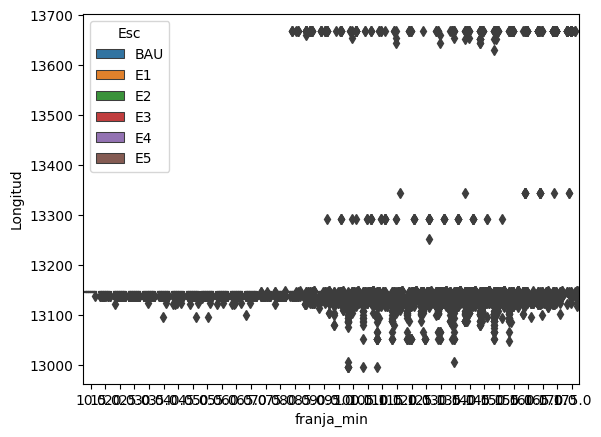

In [200]:
sns.boxplot(data = alldata[alldata['Ruta']=='auto_norte_lateral_chia'], x = 'franja_min', y='Longitud', hue = 'Esc')

In [210]:
alldata['L_mean'] = alldata.groupby(['Ruta','Esc'])['Longitud'].transform('mean')
alldata['L_std'] = alldata.groupby(['Ruta','Esc'])['Longitud'].transform('std')
alldata['z-score'] = ((alldata['Longitud']-alldata['L_mean'])/alldata['L_std']).fillna(0)

In [219]:
filtdata = alldata[np.abs(alldata['z-score'])<2]

In [220]:
print(len(alldata),len(filtdata))

3782459 3737903


<AxesSubplot: xlabel='franja_min', ylabel='Longitud'>

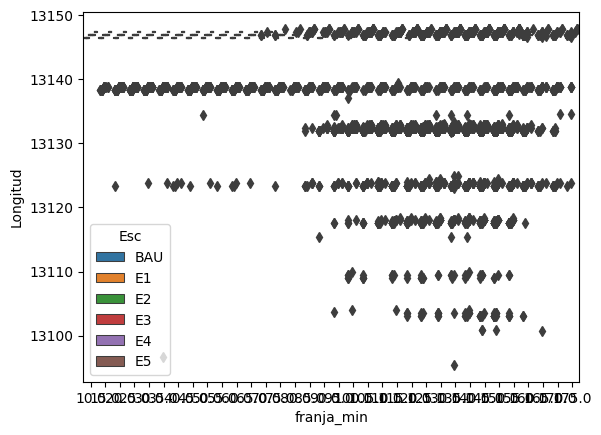

In [221]:
sns.boxplot(data = filtdata[filtdata['Ruta']=='auto_norte_lateral_chia'], x = 'franja_min', y='Longitud', hue = 'Esc')

# Speed analysis
Now we create a speed diagram for all the important routes

In [222]:
rutas_importantes = ['auto_norte_central_chia','auto_norte_lateral_chia','ruta_auto_norte_central_Cl222', 'ruta_auto_norte_central_array',
       'ruta_auto_norte_lateral_array', 'chia_auto_sur_central', 'chia_auto_sur_lateral']

<AxesSubplot: xlabel='franja_min', ylabel='velocidad'>

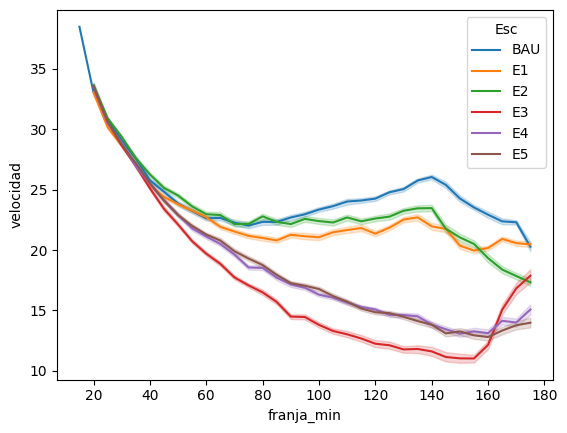

In [223]:
sns.lineplot(data = alldata[alldata['Ruta']=='ruta_auto_norte_central_Cl222'], x = 'franja_min', y='velocidad', hue = 'Esc')

[Text(0, 0, 'auto_norte_central_chia'),
 Text(1, 0, 'auto_norte_lateral_chia'),
 Text(2, 0, 'chia_auto_sur_central'),
 Text(3, 0, 'chia_auto_sur_lateral'),
 Text(4, 0, 'ruta_auto_norte_central_Cl222'),
 Text(5, 0, 'ruta_auto_norte_central_array'),
 Text(6, 0, 'ruta_auto_norte_lateral_array')]

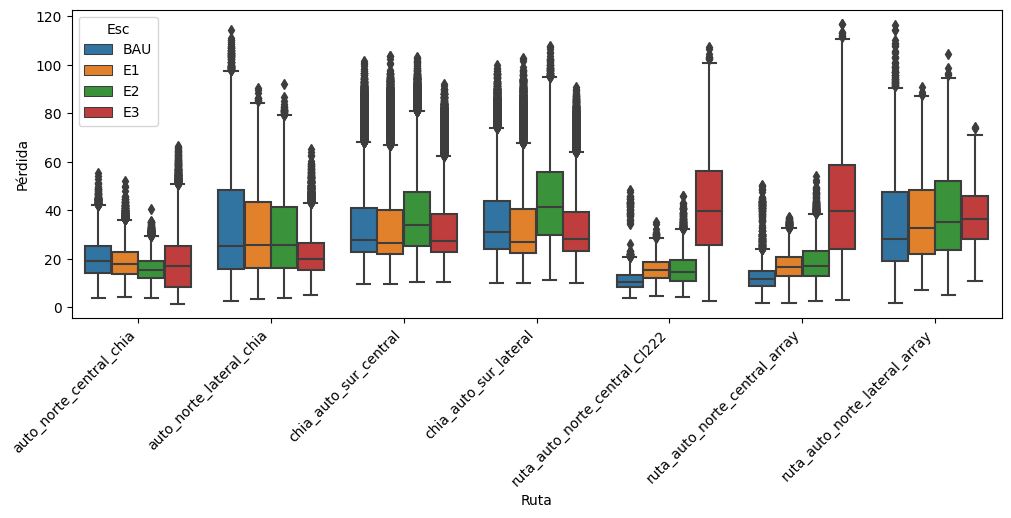

In [92]:
mask = (alldata['Ruta'].isin(rutas_importantes)) & (alldata['franja_h']==2)

fig, ax = plt.subplots(1,1,figsize=(12,4))
sns.boxplot(data = alldata[mask].sort_values(by=['Ruta','Esc']), x = 'Ruta', y='Pérdida', hue = 'Esc')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

/tmp/ipykernel_2202/1234648047.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


[Text(-2000.0, 0, '−2000'),
 Text(0.0, 0, '0'),
 Text(2000.0, 0, '2000'),
 Text(4000.0, 0, '4000'),
 Text(6000.0, 0, '6000'),
 Text(8000.0, 0, '8000'),
 Text(10000.0, 0, '10000'),
 Text(12000.0, 0, '12000')]

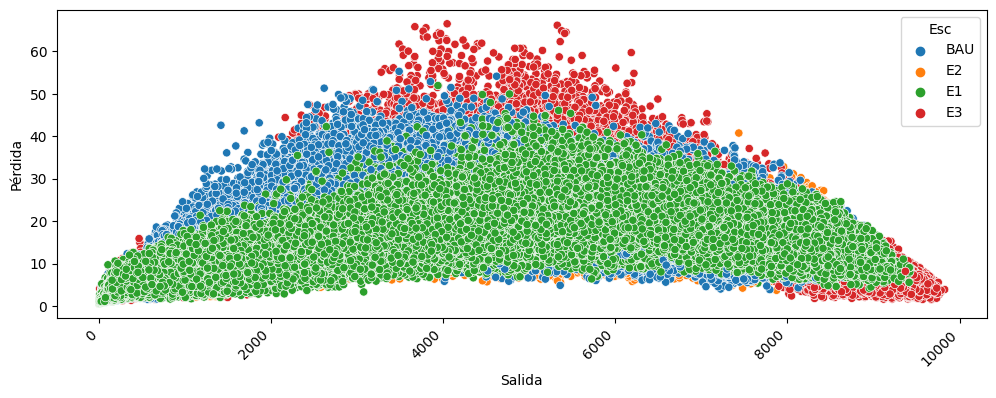

In [93]:
mask = (alldata['Ruta'].isin(rutas_importantes)) & (alldata['Ruta']==rutas_importantes[0])

fig, ax = plt.subplots(1,1,figsize=(12,4))
sns.scatterplot(data = alldata[mask].sort_values(by='Ruta'), x = 'Salida', y='Pérdida', hue = 'Esc')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

<AxesSubplot: xlabel='Pérdida', ylabel='Count'>

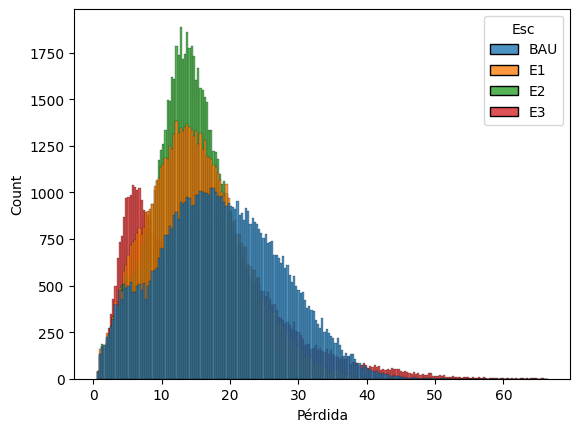

In [94]:
mask = (alldata['Ruta']==rutas_importantes[0])

sns.histplot(data = alldata[mask], x = 'Pérdida', hue = 'Esc', alpha = 0.8)

In [113]:
alldata['conteo'] = alldata.groupby(['Esc','Ruta','NSim'])['Llegada'].cumcount()

In [96]:
contdata = pd.DataFrame(alldata.groupby(['Ruta','Esc','franja_min'])['conteo'].mean())
contdata['conteo_std'] = alldata.groupby(['Ruta','Esc','franja_min'])['conteo'].std()
contdata = contdata.reset_index()

<AxesSubplot: xlabel='franja_min', ylabel='conteo'>

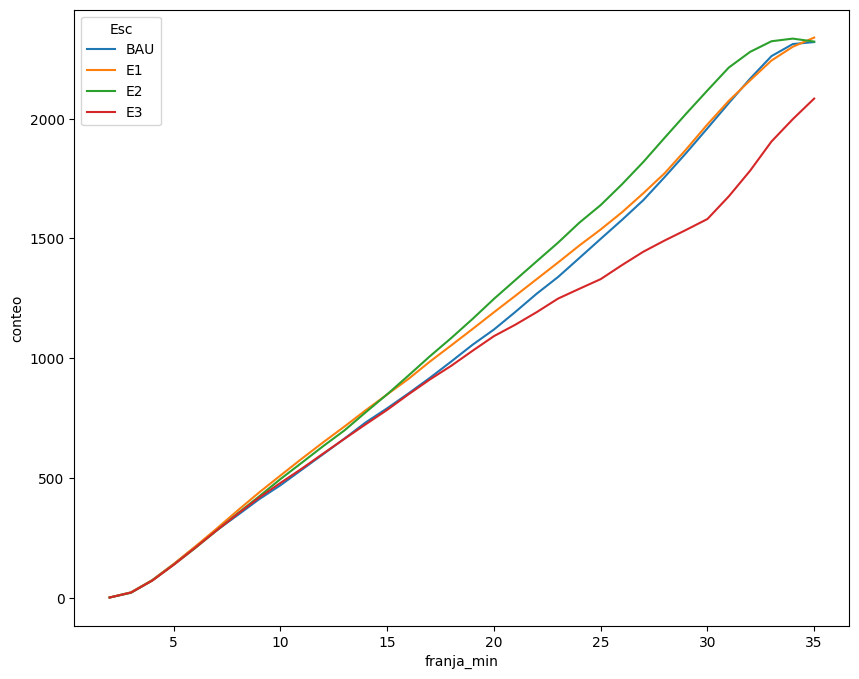

In [108]:
fig, ax = plt.subplots(figsize = (10,8))
sns.lineplot(data=contdata[contdata['Ruta']=='auto_norte_central_chia'], x='franja_min', y='conteo', hue='Esc')

In [109]:
contdata[contdata['Ruta']=='ruta_auto_norte_central_Cl222']

,Ruta,Esc,franja_min,conteo,conteo_std
5782,ruta_auto_norte_central_Cl222,BAU,3.0,0.000000,NaN
5783,ruta_auto_norte_central_Cl222,BAU,4.0,2.067797,1.981663
5784,ruta_auto_norte_central_Cl222,BAU,5.0,9.586111,4.666401
5785,ruta_auto_norte_central_Cl222,BAU,6.0,21.905371,6.223508
5786,ruta_auto_norte_central_Cl222,BAU,7.0,33.067692,6.385388
...,...,...,...,...,...
5906,ruta_auto_norte_central_Cl222,E3,31.0,227.043771,22.179735
5907,ruta_auto_norte_central_Cl222,E3,32.0,239.602771,25.122002
5908,ruta_auto_norte_central_Cl222,E3,33.0,256.533333,23.526727
5909,ruta_auto_norte_central_Cl222,E3,34.0,281.795181,22.652005


In [116]:
contdata = alldata.groupby(['Esc','Ruta','NSim','franja_min'])['Llegada'].count().reset_index()

In [118]:
contdata['time'] = contdata['franja_min']*5

<AxesSubplot: xlabel='franja_min', ylabel='velocidad'>

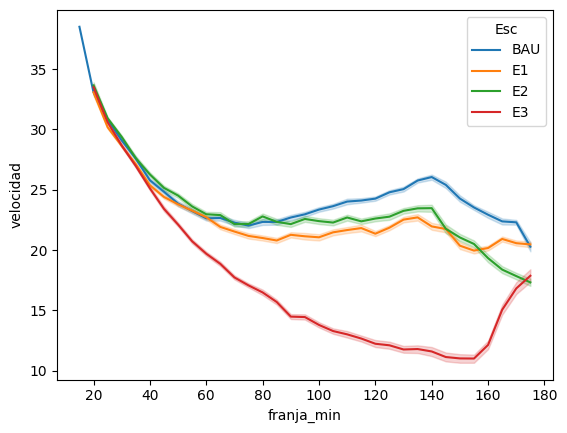

In [161]:
sns.lineplot(data = alldata[alldata['Ruta']=='ruta_auto_norte_central_Cl222'], x = 'franja_min', y='velocidad', hue = 'Esc')

In [126]:
contdata['tiempo'] = pd.to_datetime(contdata['time'], unit = 'm').dt.strftime('%H:%M')

/tmp/ipykernel_2202/1465531895.py:3: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation = 45)


[Text(0, 0, '00:10'),
 Text(1, 0, '00:15'),
 Text(2, 0, '00:20'),
 Text(3, 0, '00:25'),
 Text(4, 0, '00:30'),
 Text(5, 0, '00:35'),
 Text(6, 0, '00:40'),
 Text(7, 0, '00:45'),
 Text(8, 0, '00:50'),
 Text(9, 0, '00:55'),
 Text(10, 0, '01:00'),
 Text(11, 0, '01:05'),
 Text(12, 0, '01:10'),
 Text(13, 0, '01:15'),
 Text(14, 0, '01:20'),
 Text(15, 0, '01:25'),
 Text(16, 0, '01:30'),
 Text(17, 0, '01:35'),
 Text(18, 0, '01:40'),
 Text(19, 0, '01:45'),
 Text(20, 0, '01:50'),
 Text(21, 0, '01:55'),
 Text(22, 0, '02:00'),
 Text(23, 0, '02:05'),
 Text(24, 0, '02:10'),
 Text(25, 0, '02:15'),
 Text(26, 0, '02:20'),
 Text(27, 0, '02:25'),
 Text(28, 0, '02:30'),
 Text(29, 0, '02:35'),
 Text(30, 0, '02:40'),
 Text(31, 0, '02:45'),
 Text(32, 0, '02:50'),
 Text(33, 0, '02:55')]

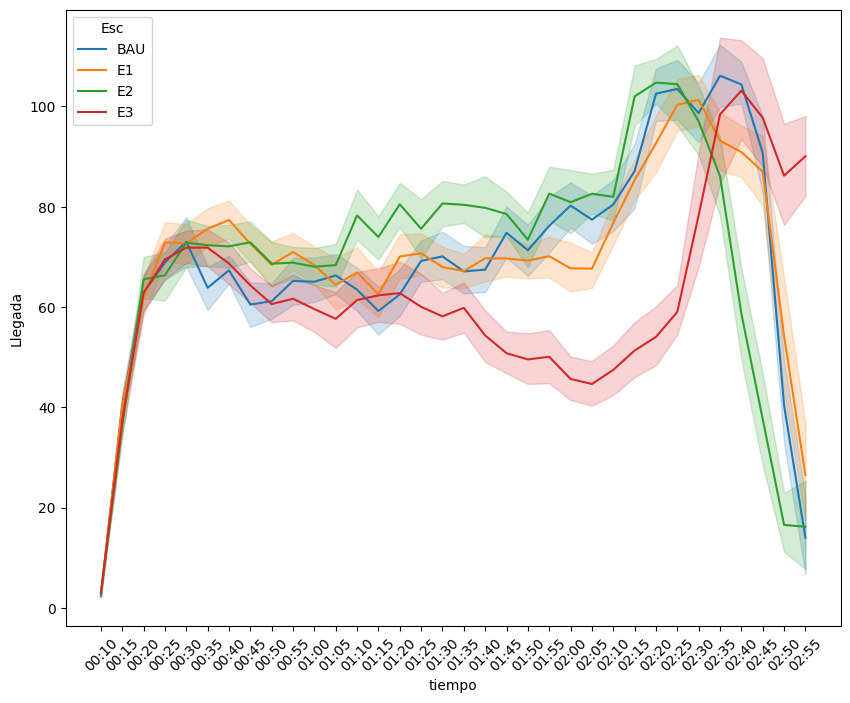

In [138]:
fig, ax = plt.subplots(figsize = (10,8))
sns.lineplot(data = contdata[contdata['Ruta']=='auto_norte_central_chia'], x = 'tiempo', y='Llegada', hue = 'Esc')
ax.set_xticklabels(ax.get_xticklabels(), rotation = 45)